In [57]:
import os
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import time
from datetime import datetime
import lpips
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [58]:
# Konfigurasi
DATASET_PATH = "processed_dataset"
MODEL_PATH = "models"
RESULTS_PATH = "results"
SCALE_FACTOR = 4
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.001

# Buat folder untuk model dan hasil
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

# GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("✅ GPU configured successfully")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("⚠️  No GPU found, using CPU")

⚠️  No GPU found, using CPU


In [59]:
def load_dataset_info():
    with open(os.path.join(DATASET_PATH, "dataset_info.json"), "r") as f:
        return json.load(f)

dataset_info = load_dataset_info()
print("Dataset Info:")
for key, value in dataset_info.items():
    print(f"  {key}: {value}")

Dataset Info:
  scale_factor: 4
  target_size: [256, 256]
  low_res_size: [64, 64]
  total_pairs: 1254
  train_pairs: 1003
  test_pairs: 251
  split_ratio: 80:20


In [60]:
def create_data_generator(split="train", batch_size=BATCH_SIZE):
    high_res_path = os.path.join(DATASET_PATH, split, "high_res")
    low_res_path = os.path.join(DATASET_PATH, split, "low_res")
    
    # Dapatkan list file
    files = sorted(os.listdir(high_res_path))
    
    def generator():
        while True:
            # Shuffle files untuk training
            if split == "train":
                np.random.shuffle(files)
            
            for i in range(0, len(files), batch_size):
                batch_files = files[i:i+batch_size]
                
                lr_batch = []
                hr_batch = []
                
                for filename in batch_files:
                    # Load low-res image
                    lr_img = cv2.imread(os.path.join(low_res_path, filename))
                    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
                    lr_img = lr_img.astype(np.float32) / 255.0
                    
                    # Load high-res image
                    hr_img = cv2.imread(os.path.join(high_res_path, filename))
                    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
                    hr_img = hr_img.astype(np.float32) / 255.0
                    
                    lr_batch.append(lr_img)
                    hr_batch.append(hr_img)
                
                yield np.array(lr_batch), np.array(hr_batch)
    
    return generator, len(files)


In [61]:
def pixel_shuffle(x):
    return tf.nn.depth_to_space(x, 4)  # Ganti 4 jika SCALE_FACTOR berbeda

def pixel_shuffle_output_shape(input_shape):
    batch, h, w, c = input_shape
    r = 4  # SCALE_FACTOR
    return (batch, h * r, w * r, c // (r * r))


In [62]:
SCALE_FACTOR = 4

# Lalu lanjut ke sini
def build_espcn_model():
    inputs = keras.Input(shape=(64, 64, 3))
    x = layers.Conv2D(64, 5, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(4 * 4 * 3, 3, padding='same')(x)

    outputs = layers.Lambda(
        pixel_shuffle,
        output_shape=pixel_shuffle_output_shape,
        name="pixel_shuffle"
    )(x)

    model = keras.Model(inputs, outputs)
    return model

# Build model
model = build_espcn_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pixel_shuffle (Lambda)          │ (None, 256, 256, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,128 (289.56 KB)

 Trainable params: 74,128 (289.56 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

In [64]:
# Setup data generators
train_generator, train_steps = create_data_generator("train", BATCH_SIZE)
test_generator, test_steps = create_data_generator("test", BATCH_SIZE)

print(f"Training steps per epoch: {train_steps // BATCH_SIZE}")
print(f"Testing steps per epoch: {test_steps // BATCH_SIZE}")


Training steps per epoch: 62
Testing steps per epoch: 15


In [65]:
# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    os.path.join(MODEL_PATH, "espcn_best.h5"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)


In [66]:
# Training model
print("🚀 Starting training...")
start_time = time.time()

history = model.fit(
    train_generator(),
    steps_per_epoch=train_steps // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator(),
    validation_steps=test_steps // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping, lr_scheduler],
    verbose=1
)

training_time = time.time() - start_time
print(f"✅ Training completed in {training_time:.2f} seconds")


🚀 Starting training...
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0780 - mae: 0.1848
Epoch 1: val_loss improved from inf to 0.01027, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - loss: 0.0774 - mae: 0.1837 - val_loss: 0.0103 - val_mae: 0.0655 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0099 - mae: 0.0637
Epoch 2: val_loss improved from 0.01027 to 0.00813, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - loss: 0.0099 - mae: 0.0636 - val_loss: 0.0081 - val_mae: 0.0569 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0078 - mae: 0.0549
Epoch 3: val_loss improved from 0.00813 to 0.00689, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - loss: 0.0078 - mae: 0.0548 - val_loss: 0.0069 - val_mae: 0.0503 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0067 - mae: 0.0491
Epoch 4: val_loss improved from 0.00689 to 0.00666, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - loss: 0.0067 - mae: 0.0491 - val_loss: 0.0067 - val_mae: 0.0481 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0067 - mae: 0.0476
Epoch 5: val_loss improved from 0.00666 to 0.00628, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0067 - mae: 0.0476 - val_loss: 0.0063 - val_mae: 0.0452 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0064 - mae: 0.0457
Epoch 6: val_loss improved from 0.00628 to 0.00614, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.0064 - mae: 0.0457 - val_loss: 0.0061 - val_mae: 0.0444 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0060 - mae: 0.0432
Epoch 7: val_loss improved from 0.00614 to 0.00610, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 0.0060 - mae: 0.0433 - val_loss: 0.0061 - val_mae: 0.0438 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0058 - mae: 0.0435
Epoch 8: val_loss improved from 0.00610 to 0.00598, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.0058 - mae: 0.0436 - val_loss: 0.0060 - val_mae: 0.0436 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0062 - mae: 0.0433
Epoch 9: val_loss improved from 0.00598 to 0.00591, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - loss: 0.0062 - mae: 0.0433 - val_loss: 0.0059 - val_mae: 0.0440 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0064 - mae: 0.0478
Epoch 10: val_loss improved from 0.00591 to 0.00590, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - loss: 0.0064 - mae: 0.0478 - val_loss: 0.0059 - val_mae: 0.0425 - learning_rate: 0.0010
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0058 - mae: 0.0417
Epoch 11: val_loss did not improve from 0.00590
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - loss: 0.0058 - mae: 0.0417 - val_loss: 0.0059 - val_mae: 0.0420 - learning_rate: 0.0010
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0055 - mae: 0.0411
Epoch 12: val_loss did not improve from 0.00590
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 0.0055 - mae: 0.0411 - val_loss: 0.0060 - val_mae: 0.0429 - learning_rate: 0.0010
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0058 - mae: 0.0418
Epoch 13: val_loss did not improve from 0.00590
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0058 - mae: 0.0418 - val_loss: 0.0061 - val_mae: 0.0462 - learning_rate: 0.0010
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0061 - mae: 0.0

62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - loss: 0.0061 - mae: 0.0441 - val_loss: 0.0056 - val_mae: 0.0406 - learning_rate: 0.0010
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0055 - mae: 0.0401
Epoch 15: val_loss did not improve from 0.00563
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - loss: 0.0055 - mae: 0.0401 - val_loss: 0.0057 - val_mae: 0.0426 - learning_rate: 0.0010
Epoch 16/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0057 - mae: 0.0425
Epoch 16: val_loss did not improve from 0.00563
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - loss: 0.0057 - mae: 0.0425 - val_loss: 0.0057 - val_mae: 0.0418 - learning_rate: 0.0010
Epoch 17/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0052 - mae: 0.0403
Epoch 17: val_loss did not improve from 0.00563
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.0052 - mae: 0.0403 - val_loss: 0.0058 - val_mae: 0.0430 - learning_rate: 0.0010
Epoch 18/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0058 - mae: 0.0

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0056 - mae: 0.0408 - val_loss: 0.0056 - val_mae: 0.0404 - learning_rate: 0.0010
Epoch 23/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0058 - mae: 0.0409
Epoch 23: val_loss improved from 0.00557 to 0.00549, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0058 - mae: 0.0409 - val_loss: 0.0055 - val_mae: 0.0400 - learning_rate: 0.0010
Epoch 24/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0054 - mae: 0.0402
Epoch 24: val_loss did not improve from 0.00549
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - loss: 0.0054 - mae: 0.0402 - val_loss: 0.0057 - val_mae: 0.0408 - learning_rate: 0.0010
Epoch 25/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0055 - mae: 0.0399
Epoch 25: val_loss did not improve from 0.00549
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.0055 - mae: 0.0399 - val_loss: 0.0057 - val_mae: 0.0405 - learning_rate: 0.0010
Epoch 26/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0055 - mae: 0.0407
Epoch 26: val_loss did not improve from 0.00549
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0055 - mae: 0.0407 - val_loss: 0.0060 - val_mae: 0.0436 - learning_rate: 0.0010
Epoch 27/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0057 - mae: 0.0

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - loss: 0.0055 - mae: 0.0405 - val_loss: 0.0055 - val_mae: 0.0397 - learning_rate: 0.0010
Epoch 29/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0057 - mae: 0.0418
Epoch 29: val_loss did not improve from 0.00548
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 0.0057 - mae: 0.0418 - val_loss: 0.0055 - val_mae: 0.0397 - learning_rate: 0.0010
Epoch 30/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0054 - mae: 0.0400
Epoch 30: val_loss did not improve from 0.00548
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0054 - mae: 0.0400 - val_loss: 0.0056 - val_mae: 0.0408 - learning_rate: 0.0010
Epoch 31/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0054 - mae: 0.0396
Epoch 31: val_loss did not improve from 0.00548
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - loss: 0.0054 - mae: 0.0396 - val_loss: 0.0056 - val_mae: 0.0410 - learning_rate: 0.0010
Epoch 32/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0059 - mae: 0.0

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0054 - mae: 0.0391 - val_loss: 0.0055 - val_mae: 0.0390 - learning_rate: 5.0000e-04
Epoch 39/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0056 - mae: 0.0399
Epoch 39: val_loss improved from 0.00546 to 0.00537, saving model to models\espcn_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.0056 - mae: 0.0399 - val_loss: 0.0054 - val_mae: 0.0387 - learning_rate: 5.0000e-04
Epoch 40/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0055 - mae: 0.0391
Epoch 40: val_loss did not improve from 0.00537
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 0.0055 - mae: 0.0391 - val_loss: 0.0056 - val_mae: 0.0395 - learning_rate: 5.0000e-04
Epoch 41/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0058 - mae: 0.0404
Epoch 41: val_loss did not improve from 0.00537
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 0.0058 - mae: 0.0404 - val_loss: 0.0056 - val_mae: 0.0398 - learning_rate: 5.0000e-04
Epoch 42/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0055 - mae: 0.0394
Epoch 42: val_loss did not improve from 0.00537
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.0055 - mae: 0.0394 - val_loss: 0.0057 - val_mae: 0.0403 - learning_rate: 5.0000e-04
Epoch 43/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0052 - mae: 0.0378 - val_loss: 0.0053 - val_mae: 0.0382 - learning_rate: 2.5000e-04
Epoch 55/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0054 - mae: 0.0387
Epoch 55: val_loss did not improve from 0.00533
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.0054 - mae: 0.0387 - val_loss: 0.0055 - val_mae: 0.0391 - learning_rate: 2.5000e-04
Epoch 56/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0054 - mae: 0.0382
Epoch 56: val_loss did not improve from 0.00533
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.0054 - mae: 0.0382 - val_loss: 0.0056 - val_mae: 0.0401 - learning_rate: 2.5000e-04
Epoch 57/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0052 - mae: 0.0377
Epoch 57: val_loss did not improve from 0.00533
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.0052 - mae: 0.0377 - val_loss: 0.0057 - val_mae: 0.0401 - learning_rate: 2.5000e-04
Epoch 58/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0

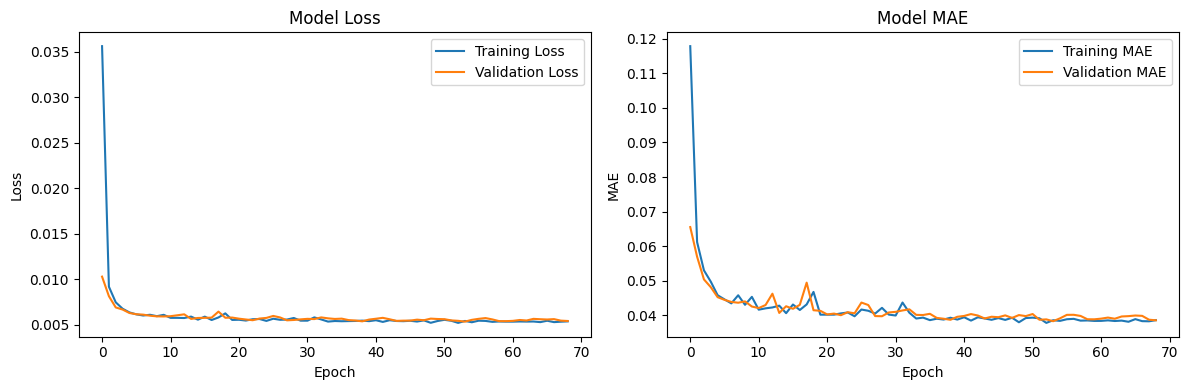

In [67]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, "training_history.png"))
    plt.show()

plot_training_history(history)

In [68]:
# Load best model
model.load_weights(os.path.join(MODEL_PATH, "espcn_best.h5"))
print("✅ Best model loaded")

✅ Best model loaded


In [69]:
# Implementasi baseline methods untuk perbandingan
def bicubic_upscale(img, scale_factor):
    """Bicubic upscaling baseline"""
    h, w = img.shape[:2]
    new_h, new_w = h * scale_factor, w * scale_factor
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

def bilinear_upscale(img, scale_factor):
    """Bilinear upscaling baseline"""
    h, w = img.shape[:2]
    new_h, new_w = h * scale_factor, w * scale_factor
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

In [70]:
# Evaluasi metrics
def calculate_psnr(img1, img2):
    """Calculate PSNR"""
    img1 = (img1 * 255).astype(np.uint8)
    img2 = (img2 * 255).astype(np.uint8)
    return psnr(img1, img2, data_range=255)

def calculate_ssim(img1, img2):
    """Calculate SSIM"""
    img1 = (img1 * 255).astype(np.uint8)
    img2 = (img2 * 255).astype(np.uint8)
    return ssim(img1, img2, data_range=255, channel_axis=2)
import torch
import torchvision.transforms as transforms

def calculate_lpips(img1, img2, lpips_model):
    # Pastikan gambar bertipe float32 dan berada di range [0, 1]
    img1 = np.clip(img1, 0, 1).astype(np.float32)
    img2 = np.clip(img2, 0, 1).astype(np.float32)

    # Convert from HWC to CHW dan batch
    img1_tensor = torch.tensor(img1).permute(2, 0, 1).unsqueeze(0)
    img2_tensor = torch.tensor(img2).permute(2, 0, 1).unsqueeze(0)

    # Kirim ke GPU jika tersedia
    if torch.cuda.is_available():
        img1_tensor = img1_tensor.cuda()
        img2_tensor = img2_tensor.cuda()
        lpips_model = lpips_model.cuda()

    # Hitung LPIPS
    with torch.no_grad():
        dist = lpips_model(img1_tensor, img2_tensor)

    return dist.item()

# Initialize LPIPS model
lpips_model = lpips.LPIPS(net='alex')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Miniconda3\envs\espcn-env\lib\site-packages\lpips\weights\v0.1\alex.pth


In [71]:
def evaluate_model():
    test_files = sorted(os.listdir(os.path.join(DATASET_PATH, "test", "high_res")))
    
    espcn_psnr = []
    espcn_ssim = []
    espcn_lpips = []
    
    bicubic_psnr = []
    bicubic_ssim = []
    bicubic_lpips = []
    
    bilinear_psnr = []
    bilinear_ssim = []
    bilinear_lpips = []
    
    print("🔍 Evaluating model...")
    
    for filename in tqdm(test_files[:50]):  # Evaluate first 50 images
        # Load images
        hr_path = os.path.join(DATASET_PATH, "test", "high_res", filename)
        lr_path = os.path.join(DATASET_PATH, "test", "low_res", filename)
        
        hr_img = cv2.imread(hr_path)
        lr_img = cv2.imread(lr_path)
        
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        
        # ESPCN prediction
        lr_batch = np.expand_dims(lr_img, axis=0)
        espcn_pred = model.predict(lr_batch, verbose=0)[0]
        espcn_pred = np.clip(espcn_pred, 0, 1)
        
        # Baseline methods
        bicubic_pred = bicubic_upscale(lr_img, SCALE_FACTOR)
        bilinear_pred = bilinear_upscale(lr_img, SCALE_FACTOR)
        
        # Calculate metrics
        # ESPCN
        espcn_psnr.append(calculate_psnr(hr_img, espcn_pred))
        espcn_ssim.append(calculate_ssim(hr_img, espcn_pred))
        espcn_lpips.append(calculate_lpips(hr_img, espcn_pred, lpips_model))
        
        # Bicubic
        bicubic_psnr.append(calculate_psnr(hr_img, bicubic_pred))
        bicubic_ssim.append(calculate_ssim(hr_img, bicubic_pred))
        bicubic_lpips.append(calculate_lpips(hr_img, bicubic_pred, lpips_model))
        
        # Bilinear
        bilinear_psnr.append(calculate_psnr(hr_img, bilinear_pred))
        bilinear_ssim.append(calculate_ssim(hr_img, bilinear_pred))
        bilinear_lpips.append(calculate_lpips(hr_img, bilinear_pred, lpips_model))
    
    # Calculate averages
    results = {
        "ESPCN": {
            "PSNR": np.mean(espcn_psnr),
            "SSIM": np.mean(espcn_ssim),
            "LPIPS": np.mean(espcn_lpips)
        },
        "Bicubic": {
            "PSNR": np.mean(bicubic_psnr),
            "SSIM": np.mean(bicubic_ssim),
            "LPIPS": np.mean(bicubic_lpips)
        },
        "Bilinear": {
            "PSNR": np.mean(bilinear_psnr),
            "SSIM": np.mean(bilinear_ssim),
            "LPIPS": np.mean(bilinear_lpips)
        }
    }
    
    return results

# Run evaluation
evaluation_results = evaluate_model()

🔍 Evaluating model...


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


In [72]:
# Print evaluation results
print("="*60)
print("EVALUATION RESULTS")
print("="*60)

for method, metrics in evaluation_results.items():
    print(f"\n{method}:")
    print(f"  PSNR: {metrics['PSNR']:.4f} dB")
    print(f"  SSIM: {metrics['SSIM']:.4f}")
    print(f"  LPIPS: {metrics['LPIPS']:.4f}")

# Save results
with open(os.path.join(RESULTS_PATH, "evaluation_results.json"), "w") as f:
    json.dump(evaluation_results, f, indent=2)

EVALUATION RESULTS

ESPCN:
  PSNR: 25.0054 dB
  SSIM: 0.6817
  LPIPS: 0.3526

Bicubic:
  PSNR: 20.6883 dB
  SSIM: 0.6585
  LPIPS: 0.4367

Bilinear:
  PSNR: 24.8293 dB
  SSIM: 0.6957
  LPIPS: 0.4081


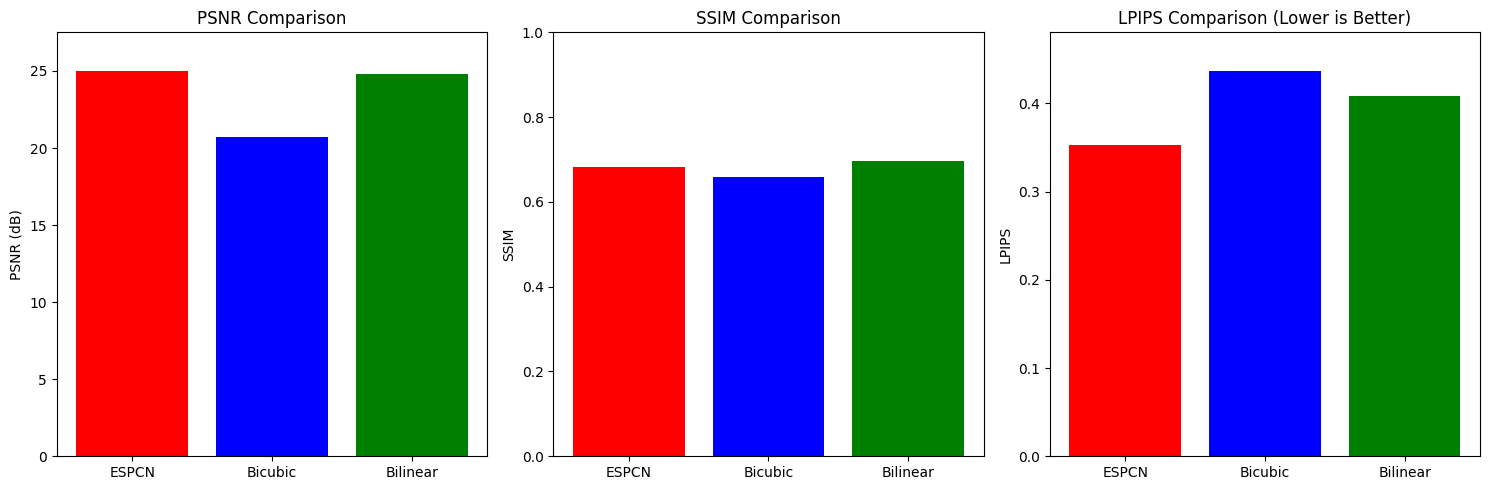

In [73]:
def plot_metrics_comparison():
    """Plot comparison metrics"""
    methods = list(evaluation_results.keys())
    psnr_values = [evaluation_results[method]["PSNR"] for method in methods]
    ssim_values = [evaluation_results[method]["SSIM"] for method in methods]
    lpips_values = [evaluation_results[method]["LPIPS"] for method in methods]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # PSNR
    axes[0].bar(methods, psnr_values, color=['red', 'blue', 'green'])
    axes[0].set_title('PSNR Comparison')
    axes[0].set_ylabel('PSNR (dB)')
    axes[0].set_ylim(0, max(psnr_values) * 1.1)
    
    # SSIM
    axes[1].bar(methods, ssim_values, color=['red', 'blue', 'green'])
    axes[1].set_title('SSIM Comparison')
    axes[1].set_ylabel('SSIM')
    axes[1].set_ylim(0, 1)
    
    # LPIPS (lower is better)
    axes[2].bar(methods, lpips_values, color=['red', 'blue', 'green'])
    axes[2].set_title('LPIPS Comparison (Lower is Better)')
    axes[2].set_ylabel('LPIPS')
    axes[2].set_ylim(0, max(lpips_values) * 1.1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, "metrics_comparison.png"))
    plt.show()

plot_metrics_comparison()

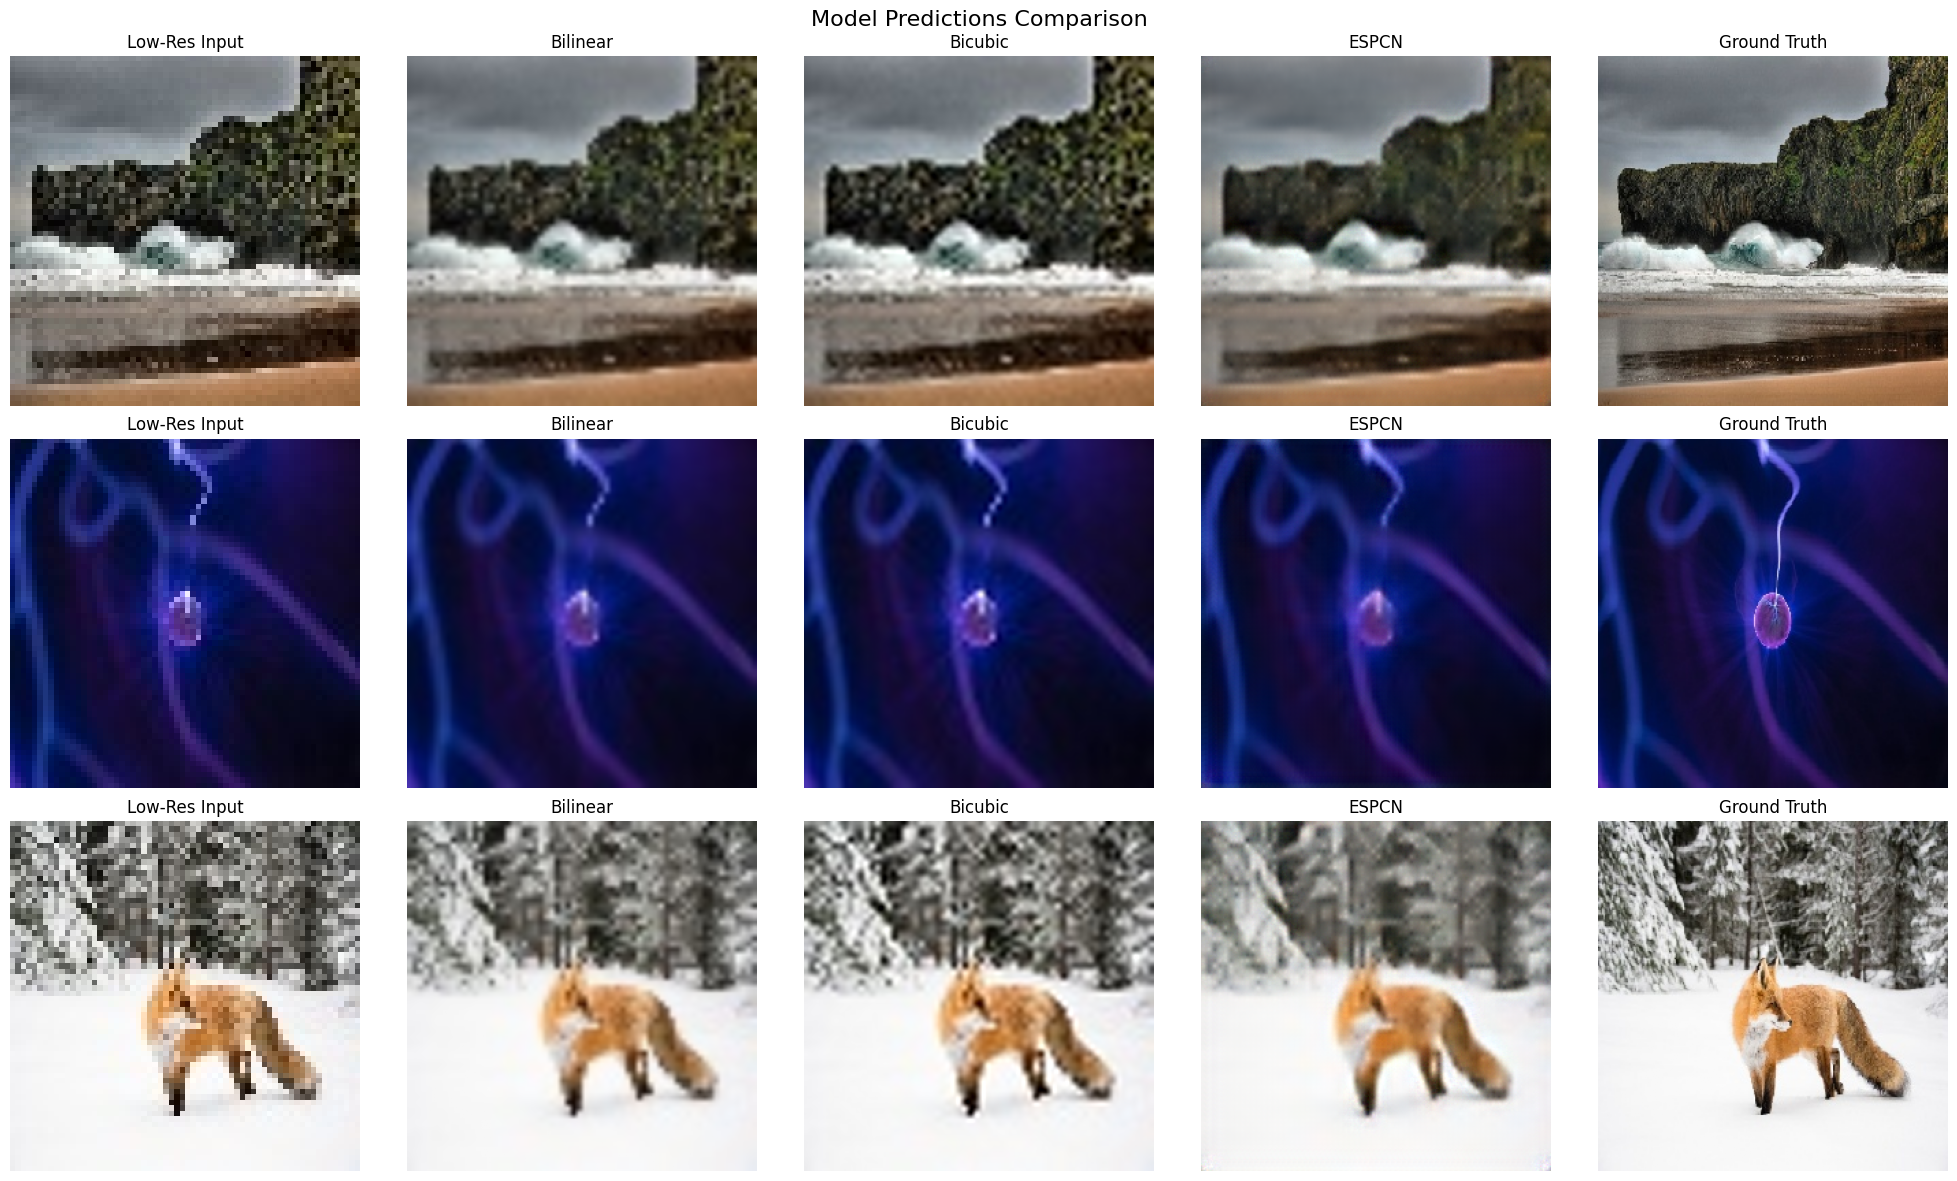

In [74]:
# Visualisasi hasil prediksi
def visualize_predictions(num_samples=3):
    """Visualisasi prediksi model"""
    test_files = sorted(os.listdir(os.path.join(DATASET_PATH, "test", "high_res")))
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    fig.suptitle("Model Predictions Comparison", fontsize=16)
    
    for i in range(num_samples):
        filename = test_files[i]
        
        # Load images
        hr_path = os.path.join(DATASET_PATH, "test", "high_res", filename)
        lr_path = os.path.join(DATASET_PATH, "test", "low_res", filename)
        
        hr_img = cv2.imread(hr_path)
        lr_img = cv2.imread(lr_path)
        
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        
        # Predictions
        lr_batch = np.expand_dims(lr_img, axis=0)
        espcn_pred = model.predict(lr_batch, verbose=0)[0]
        espcn_pred = np.clip(espcn_pred, 0, 1)
        
        bicubic_pred = bicubic_upscale(lr_img, SCALE_FACTOR)
        bilinear_pred = bilinear_upscale(lr_img, SCALE_FACTOR)
        
        # Plot
        axes[i, 0].imshow(lr_img)
        axes[i, 0].set_title("Low-Res Input")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(bilinear_pred)
        axes[i, 1].set_title("Bilinear")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(bicubic_pred)
        axes[i, 2].set_title("Bicubic")
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(espcn_pred)
        axes[i, 3].set_title("ESPCN")
        axes[i, 3].axis('off')
        
        axes[i, 4].imshow(hr_img)
        axes[i, 4].set_title("Ground Truth")
        axes[i, 4].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, "predictions_comparison.png"), dpi=150)
    plt.show()

visualize_predictions(3)

In [75]:
model.save(os.path.join(MODEL_PATH, "espcn_final.h5"))
print("✅ Model saved for GUI application")


✅ Model saved for GUI application


In [76]:
# Training summary
def save_training_summary():
    """Save training summary"""
    summary = {
        "model_name": "ESPCN",
        "scale_factor": SCALE_FACTOR,
        "training_time": training_time,
        "epochs_trained": len(history.history['loss']),
        "best_val_loss": min(history.history['val_loss']),
        "evaluation_results": evaluation_results,
        "dataset_info": dataset_info,
        "hyperparameters": {
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE,
            "optimizer": "Adam",
            "loss_function": "MSE"
        },
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    with open(os.path.join(RESULTS_PATH, "training_summary.json"), "w") as f:
        json.dump(summary, f, indent=2)
    
    print("Training Summary:")
    print(f"  Model: {summary['model_name']}")
    print(f"  Scale Factor: {summary['scale_factor']}x")
    print(f"  Training Time: {summary['training_time']:.2f} seconds")
    print(f"  Epochs: {summary['epochs_trained']}")
    print(f"  Best Validation Loss: {summary['best_val_loss']:.6f}")
    print(f"  Timestamp: {summary['timestamp']}")

save_training_summary()


Training Summary:
  Model: ESPCN
  Scale Factor: 4x
  Training Time: 745.59 seconds
  Epochs: 69
  Best Validation Loss: 0.005332
  Timestamp: 2025-07-09 23:35:19


In [77]:
# Test inference speed
def test_inference_speed():
    """Test inference speed"""
    test_file = sorted(os.listdir(os.path.join(DATASET_PATH, "test", "low_res")))[0]
    lr_path = os.path.join(DATASET_PATH, "test", "low_res", test_file)
    
    lr_img = cv2.imread(lr_path)
    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    lr_batch = np.expand_dims(lr_img, axis=0)
    
    # Warm up
    for _ in range(5):
        _ = model.predict(lr_batch, verbose=0)
    
    # Measure inference time
    times = []
    for _ in range(100):
        start_time = time.time()
        _ = model.predict(lr_batch, verbose=0)
        times.append(time.time() - start_time)
    
    avg_time = np.mean(times)
    fps = 1.0 / avg_time
    
    print(f"Inference Speed:")
    print(f"  Average time: {avg_time:.4f} seconds")
    print(f"  FPS: {fps:.2f}")
    
    return avg_time, fps

inference_time, fps = test_inference_speed()

Inference Speed:
  Average time: 0.0953 seconds
  FPS: 10.49
